- TITLE: 
- AUTHOR: John Kitchin


[./lecture-06.ipynb](./lecture-06.ipynb)


# Engineering applications of mole balances

So far you have learned to design a variety of reactors with single reactions occurring in them. Usually, we need additional information to tell us which reactor design is better, e.g. a larger volume with low volumetric flow rate vs. a smaller volume with higher volumetric flow rate. That information may be the cost of different configurations, or the profit from different configurations. Today we integrate some of these ideas.


## Total cost example

Let us consider a simple model for the total cost of an operation. Let the total cost be the operating cost of the reactor plus the cost of the feedstocks. 

The operating cost of a reactor can be determined by amortizing the reactor cost over some length of time, and adding the cost required for maintenance, and paying workers.

-   The units of this cost will usually be dollars/volume/time
-   The cost of operating the reactor then is $C_R = V_R operating_{cost}$

Feedstock costs are related to the cost of raw materials times the rate at which they are consumed.

-   The cost associated with each reactant will be $C_{j} = F_j reactant_{cost}$ if $reactant_{cost}$ is in $/mol.

Let us consider an example. $Y$ is produced at a rate of 90 kmol/min in a CSTR by the reaction $X \rightarrow Y$ at a reaction rate of $r = 0.1 C_X$ (kmol/m^3/min)  with an inlet concentration of $C_{X0} = 1.5$ kmol/m^3.  The reactant $X$ costs $1.20 per kmol. The cost of the reactor is 0.1 per minute per cubic meter. If we discard unreacted X, what is the minimum cost of making Y?

We need to know the volume and volumetric flow that will minimize the total cost.

We have a mole balance on X:

\begin{align}
0 = F_{X0} - F_X + r_X V \\
0 = F_{X0} - C_X v_0 - k C_X V
\end{align}

We have two unknowns and one equation, but if we specify one variable, we can solve for the other one.

Let us start by specifying a $v_0$, and solving for $V$, then we calculate the cost. Then we vary $v_0$ to minimize the cost.

There are some bounds on $v_0$: We must have at least 90 kmol/min of X entering the reactor to produce 90 kmol/min of Y

-   Actually that would be a conversion of 100%, which is not reasonable.
-   Let us assume 90% conversion is acceptable for now, which means $v_0$ must be at least 100 kmol/min / 1.5 mol/m<sup>3</sup> &asymp; 66 m<sup>3</sup>/min.

First we define what we know.



In [1]:
from scipy.optimize import fsolve
import numpy as np

k = 0.1    # rate constant 1/min
Cx0 = 1.5  # initial concentration M
Fy = 90.0  # exit molar flow of Y mol/min

reactor_cost = 0.1  # $/m^3
Xcost = 1.20        # $/kmol

Next, we can define an objective function. This is the function we need to solve to find the volume of a reactor if the volumetric flow is specified. We define it like a regular objective function, but we add a second argument that will be a *parameter* for the volumetric flow.



In [1]:
def objective(V, v0):
    Fx0 = Cx0 * v0
    Fx = Fx0 - Fy
    Cx = Fx / v0
    rx = -k * Cx
    return Fx0 - Fx + rx * V

Then, we define a range of volumetric flows to calculate the cost for, and a function for the cost. So we will create a range of volumetric flows from 66 to 200 m^3/min. For each value, we pass it as an args parameter to the objective function, and then we solve for the reactor volume. Once we have the volume we can calculate the reactor cost, and with the volumetric flow calculate the reactant cost. Finally, we compute the cost of the operation. If we have selected the initial range correctly, we will see a minimum.



In [1]:
from scipy.optimize import fsolve
import numpy as np

v0 = np.linspace(66, 200)

def cost_func(vol_flow):
    V, = fsolve(objective, 10000, args=(vol_flow,))
    CR = reactor_cost * V
    CX = vol_flow * Cx0 * Xcost
    return (CR + CX) / Fy  # cost in $/mol Y

cost = [cost_func(v) for v in v0]

Now we plot the cost function.



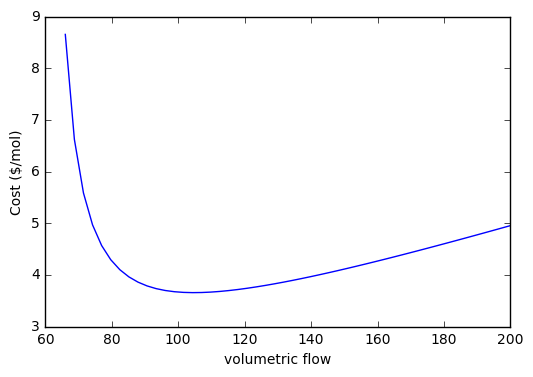

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(v0, cost)
plt.xlabel('volumetric flow')
plt.ylabel('Cost ($/mol)')

Here we get the approximate minimum of the cost, and the corresponding volumetric flow.



In [1]:
imin = np.argmin(cost)
print('Min cost of ${} at V={}'.format(cost[imin], v0[imin]))

Min cost of $3.655606758832566 at V=104.28571428571428

The cost at low volumetric flow is dominated by the increasing reactor size. The cost at high volumetric flow is dominated by the cost of the feedstock $X$. 

**Exercise**: Show that the costs in the example above are dominated by reactor volume at low flowrate, and reactant cost at high flowrate.


# Profit example

Now, let us consider profit. Profit is the difference between the value of the products and the cost to make them. Say compound X with a concentration of 2.5 kmol / m<sup>3</sup> flows at a rate of 12 m<sup>3</sup>/min into a tubular reactor where it is converted to $Y$.

The reaction occurs at a rate of $r = 30.0 C_X$ 1/min. $Y$ has a value $V_Y$ of $1.50 / kmol, and the cost of reactor operation $C_R$ is $2.50 per minute per m<sup>3</sup>. What is the maximum profit?

The value of the products will be $F_Y V_Y$ and the operating cost will be $V_R C_R$. We have to compute the exit molar flow of product as a function of reactor volume, and then compute the profit for each volume.

Here we set up mole balances on $X$ and $Y$.

-   It is not strictly necessary, we could just get $F_X$, and compute $F_Y$ by stoichiometry later
-   Instead, we compute $F_Y$ in the solution

As before we start by defining what we know.



In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

k = 30.0
CX0 = 2.5 # kmol / m^3
v0 = 12.0 # m^3 / min
FX0 = CX0 * v0
FY0 = 0.0

Next we define the ODE and solve it. Note we have two coupled ODEs here:

$\frac{dF_x}{dV} = r_x$

$\frac{dF_y}{dV} = r_y$

with

$r = k C_x$

and by stoichiometry:

\frac{r_x}{-1} = \frac{r_y}{1} = r$.

So, the first variable to our ode function will actually hold two values: $F_x$ and $F_y$, and the function must return two values, one for each ode.



In [1]:
def dFdV(F, V):
    Fx, Fy = F
    Cx = Fx / v0
    r = k * Cx
    rx = -r
    ry =  r
    dFxdV = rx
    dFydV = ry
    return [dFxdV, dFydV]

Vspan = np.linspace(0, 3)

sol = odeint(dFdV, [FX0, FY0], Vspan)

Fy = sol[:, 1]

With the solution in hand, we can calculate the product value and operating cost, and finally the profit.



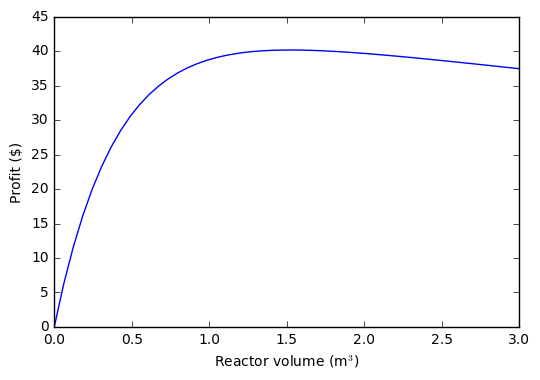

In [1]:
V_Y = 1.50 # $/kmol
C_R = 2.50 # $/m^3/min

product_value = Fy * V_Y
operating_cost = Vspan * C_R

profit = product_value - operating_cost
plt.plot(Vspan, profit)
plt.xlabel('Reactor volume (m$^3$)')
plt.ylabel('Profit ($)')

As before we can estimate the maximum pretty accurately with the index of the maximum value in the profit array.



In [1]:
imax = np.argmax(profit)
print(imax)
print('Max profit of ${} at V = {}'.format(profit[imax], Vspan[imax]))

You can see a maximum in profit at a reactor volume of about 1.5 m<sup>3</sup>. To get a more quantitative answer, we need to use optimization. We need to define an objective function to minimize.  The profit goes through a maximum, so -profit will go through a minimum. 

We will use an optional argument to our profit function that determines the sign of the return value. For the optimization we set the sign to be -1. After we have a solution we use the default sign of +1 to compute the profit. This is just for convenience. You could multiply by &plusmn; 1 as needed.



In [1]:
def profit(V, sign=1):
   F = odeint(dFdV, [FX0, FY0], [0, V])
   FY = F[-1, 1]
   profit = FY * V_Y - V * C_R
   return profit * sign

print(profit(1.53))

from scipy.optimize import fmin

opt_V, = fmin(profit, 1.5, args=(-1,))
print('Maximum profit is {} at V = {}'.format(profit(opt_V), opt_V))

40.1931703548
Optimization terminated successfully.
         Current function value: -40.193337
         Iterations: 11
         Function evaluations: 22
Maximum profit is 40.19333745971681 at V = 1.5226318359375